In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import os
from tqdm.notebook import tqdm

In [2]:
#!pip install matplotlib

In [3]:
path = "./"

calendar = pd.read_csv(os.path.join(path, "calendar.csv"))
selling_prices = pd.read_csv(os.path.join(path, "sell_prices.csv"))
sample_submission = pd.read_csv(os.path.join(path, "sample_submission.csv"))
sales = pd.read_csv(os.path.join(path, "sales_train_validation.csv"))

In [4]:
!ls

20200508(1).ipynb   sales.csv			    sell_prices.csv.zip
20200508(2).ipynb   sales_train_validation.csv	    submission.csv
Untitled1.ipynb     sales_train_validation.csv.zip  train.bin
calendar.csv	    sample_submission.csv	    url.txt
docker_command.txt  sample_submission.csv.zip	    valid_data_label.npz
model.txt	    sell_prices.csv


In [5]:
#!apt-get install unzip

In [6]:
#!unzip sales_train_validation.csv.zip

In [7]:
#!unzip sample_submission.csv.zip

In [8]:
#!unzip sell_prices.csv.zip

In [9]:
from sklearn.preprocessing import OrdinalEncoder

def prep_calendar(df):
    df = df.drop(["date", "weekday", "event_name_2", "event_type_2"], axis=1)
    df = df.assign(d = df.d.str[2:].astype(int))
    to_ordinal = ["event_name_1", "event_type_1"] 
    df[to_ordinal] = df[to_ordinal].fillna("1")
    df[to_ordinal] = OrdinalEncoder(dtype="int").fit_transform(df[to_ordinal]) + 1
    to_int8 = ["wday", "month", "snap_CA", "snap_TX", "snap_WI"] + to_ordinal
    df[to_int8] = df[to_int8].astype("int8")
    return df

calendar = prep_calendar(calendar)
calendar.head()

,wm_yr_wk,wday,month,year,d,event_name_1,event_type_1,snap_CA,snap_TX,snap_WI
0,11101,1,1,2011,1,1,1,0,0,0
1,11101,2,1,2011,2,1,1,0,0,0
2,11101,3,1,2011,3,1,1,0,0,0
3,11101,4,2,2011,4,1,1,1,1,0
4,11101,5,2,2011,5,1,1,1,0,1


In [10]:
def prep_selling_prices(df):
    gr = df.groupby(["store_id", "item_id"])["sell_price"]
    df["sell_price_rel_diff"] = gr.pct_change()
    df["sell_price_cumrel"] = (gr.shift(0) - gr.cummin()) / (1 + gr.cummax() - gr.cummin())
    df["sell_price_roll_sd7"] = gr.transform(lambda x: x.rolling(7).std())
    to_float32 = ["sell_price", "sell_price_rel_diff", "sell_price_cumrel", "sell_price_roll_sd7"]
    df[to_float32] = df[to_float32].astype("float32")
         
    return df

selling_prices = prep_selling_prices(selling_prices)
selling_prices.head(14)

,store_id,item_id,wm_yr_wk,sell_price,sell_price_rel_diff,sell_price_cumrel,sell_price_roll_sd7
0,CA_1,HOBBIES_1_001,11325,9.58,NaN,0.0,NaN
1,CA_1,HOBBIES_1_001,11326,9.58,0.000000,0.0,NaN
2,CA_1,HOBBIES_1_001,11327,8.26,-0.137787,0.0,NaN
3,CA_1,HOBBIES_1_001,11328,8.26,0.000000,0.0,NaN
4,CA_1,HOBBIES_1_001,11329,8.26,0.000000,0.0,NaN
5,CA_1,HOBBIES_1_001,11330,8.26,0.000000,0.0,NaN
6,CA_1,HOBBIES_1_001,11331,8.26,0.000000,0.0,6.440940e-01
7,CA_1,HOBBIES_1_001,11332,8.26,0.000000,0.0,4.989131e-01
8,CA_1,HOBBIES_1_001,11333,8.26,0.000000,0.0,1.360284e-08
9,CA_1,HOBBIES_1_001,11334,8.26,0.000000,0.0,1.360284e-08


In [11]:
def reshape_sales(df, drop_d = None):
    if drop_d is not None:
        df = df.drop(["d_" + str(i+1) for i in range(drop_d-1)], axis=1)
    df = df.assign(id=df.id.str.replace("_validation", ""))
    df = df.reindex(columns=df.columns.tolist() + ["d_" + str(1913 + i + 1) for i in range(2 * 28)])
    df = df.melt(id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
                 var_name='d', value_name='demand')
    df = df.assign(d=df.d.str[2:].astype("int64"))

    return df

sales = reshape_sales(sales, 1000)

In [12]:
ids = sales.columns[sales.columns.str.contains("id")]

In [13]:
ids = ids[:1]
print(ids)

Index(['id'], dtype='object')


In [14]:
'''
def prep_sales(df):
    df['lag_t28'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28))
    df['rolling_mean_t7'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(7).mean())
    df['rolling_mean_t30'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).mean())
    df['rolling_mean_t60'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(60).mean())
    df['rolling_mean_t90'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(90).mean())
    df['rolling_mean_t180'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(180).mean())
    df['rolling_std_t7'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(7).std())
    df['rolling_std_t30'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).std())
  
    to_float32 = ['lag_t28', 'rolling_mean_t7', 'rolling_mean_t30', 'rolling_mean_t60', 
                  'rolling_mean_t90', 'rolling_mean_t180', 'rolling_std_t7', 'rolling_std_t30']
    df[to_float32] = df[to_float32].astype("float32")
    
    # Remove rows with NAs except for submission rows. rolling_mean_t180 was selected as it produces most missings
    df = df[(df.d >= 1914) | (pd.notna(df.rolling_mean_t180))]
 
    return df

sales = prep_sales(sales)
'''

'\ndef prep_sales(df):\n    df[\'lag_t28\'] = df.groupby([\'id\'])[\'demand\'].transform(lambda x: x.shift(28))\n    df[\'rolling_mean_t7\'] = df.groupby([\'id\'])[\'demand\'].transform(lambda x: x.shift(28).rolling(7).mean())\n    df[\'rolling_mean_t30\'] = df.groupby([\'id\'])[\'demand\'].transform(lambda x: x.shift(28).rolling(30).mean())\n    df[\'rolling_mean_t60\'] = df.groupby([\'id\'])[\'demand\'].transform(lambda x: x.shift(28).rolling(60).mean())\n    df[\'rolling_mean_t90\'] = df.groupby([\'id\'])[\'demand\'].transform(lambda x: x.shift(28).rolling(90).mean())\n    df[\'rolling_mean_t180\'] = df.groupby([\'id\'])[\'demand\'].transform(lambda x: x.shift(28).rolling(180).mean())\n    df[\'rolling_std_t7\'] = df.groupby([\'id\'])[\'demand\'].transform(lambda x: x.shift(28).rolling(7).std())\n    df[\'rolling_std_t30\'] = df.groupby([\'id\'])[\'demand\'].transform(lambda x: x.shift(28).rolling(30).std())\n  \n    to_float32 = [\'lag_t28\', \'rolling_mean_t7\', \'rolling_mean_t30

In [15]:
'''
def prep_sales_ex(df, subid=None):
    new_col_01 = 'lag_t28_' + subid
    new_col_02 = 'rolling_mean_t7_' + subid
    new_col_03 = 'rolling_mean_t30_' + subid
    new_col_04 = 'rolling_mean_t60_' + subid
    new_col_05 = 'rolling_mean_t90_' + subid
    new_col_06 = 'rolling_mean_t180_' + subid
    new_col_07 = 'rolling_std_t7_' + subid
    new_col_08 = 'rolling_std_t30_' + subid
    #new_col_09 = 'rolling_std_t60_' + subid
    new_col_09 = 'rolling_mean_t14_' + subid
    df[new_col_01] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28))
    df[new_col_02] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7).mean())
    df[new_col_03] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(30).mean())
    df[new_col_04] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(60).mean())
    df[new_col_05] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(90).mean())
    df[new_col_06] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(180).mean())
    df[new_col_07] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7).std())
    df[new_col_08] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(30).std())
    #df[new_col_09] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(60).std())
    df[new_col_09] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*2).std())
  
    to_float32 = [new_col_01, new_col_02, new_col_03, new_col_04, new_col_05, new_col_06, new_col_07, new_col_08, new_col_09]
    df[to_float32] = df[to_float32].astype("float32")
    
    # Remove rows with NAs except for submission rows. rolling_mean_t180 was selected as it produces most missings
    df = df[(df.d >= 1914) | (pd.notna(df[new_col_06]))]
 
    return df

for subid in ids:
    sales = prep_sales_ex(sales, subid=subid)
'''

'\ndef prep_sales_ex(df, subid=None):\n    new_col_01 = \'lag_t28_\' + subid\n    new_col_02 = \'rolling_mean_t7_\' + subid\n    new_col_03 = \'rolling_mean_t30_\' + subid\n    new_col_04 = \'rolling_mean_t60_\' + subid\n    new_col_05 = \'rolling_mean_t90_\' + subid\n    new_col_06 = \'rolling_mean_t180_\' + subid\n    new_col_07 = \'rolling_std_t7_\' + subid\n    new_col_08 = \'rolling_std_t30_\' + subid\n    #new_col_09 = \'rolling_std_t60_\' + subid\n    new_col_09 = \'rolling_mean_t14_\' + subid\n    df[new_col_01] = df.groupby([subid])[\'demand\'].transform(lambda x: x.shift(28))\n    df[new_col_02] = df.groupby([subid])[\'demand\'].transform(lambda x: x.shift(28).rolling(7).mean())\n    df[new_col_03] = df.groupby([subid])[\'demand\'].transform(lambda x: x.shift(28).rolling(30).mean())\n    df[new_col_04] = df.groupby([subid])[\'demand\'].transform(lambda x: x.shift(28).rolling(60).mean())\n    df[new_col_05] = df.groupby([subid])[\'demand\'].transform(lambda x: x.shift(28).roll

In [16]:
def prep_sales_ex(df, subid=None):
    #new_col_01 = 'lag_t7_' + subid
    #new_col_02 = 'lag_t14_' + subid
    #new_col_03 = 'lag_t21_' + subid
    new_col_04 = 'lag_t28_' + subid
    #new_col_05 = 'lag_t63_' + subid
    #new_col_06 = 'lag_t84_' + subid
    #new_col_07 = 'lag_t182_' + subid
    
    new_col_08 = 'rolling_mean_t7_' + subid
    new_col_09 = 'rolling_mean_t14_' + subid
    new_col_10 = 'rolling_mean_t21_' + subid
    new_col_11 = 'rolling_mean_t28_' + subid
    new_col_28 = 'rolling_mean_t35_' + subid
    new_col_29 = 'rolling_mean_t42_' + subid
    new_col_30 = 'rolling_mean_t49_' + subid
    new_col_31 = 'rolling_mean_t56_' + subid
    new_col_12 = 'rolling_mean_t63_' + subid
    new_col_13 = 'rolling_mean_t84_' + subid
    new_col_14 = 'rolling_mean_t182_' + subid
    new_col_27 = 'rolling_mean_t364_' + subid
    
    new_col_15 = 'rolling_std_t7_' + subid
    new_col_16 = 'rolling_std_t14_' + subid
    new_col_17 = 'rolling_std_t21_' + subid
    new_col_18 = 'rolling_std_t28_' + subid
    new_col_19 = 'rolling_std_t35_' + subid
    new_col_20 = 'rolling_std_t42_' + subid
    new_col_21 = 'rolling_std_t49_' + subid
    new_col_22 = 'rolling_std_t56_' + subid
    new_col_23 = 'rolling_std_t63_' + subid
    new_col_24 = 'rolling_std_t84_' + subid
    new_col_25 = 'rolling_std_t182_' + subid
    new_col_26 = 'rolling_std_t364_' + subid
    
    
    #df[new_col_01] = df.groupby([subid])['demand'].transform(lambda x: x.shift(7))
    #df[new_col_02] = df.groupby([subid])['demand'].transform(lambda x: x.shift(7*2))
    #df[new_col_03] = df.groupby([subid])['demand'].transform(lambda x: x.shift(7*3))
    df[new_col_04] = df.groupby([subid])['demand'].transform(lambda x: x.shift(7*4))
    #df[new_col_05] = df.groupby([subid])['demand'].transform(lambda x: x.shift(7*9))
    #df[new_col_06] = df.groupby([subid])['demand'].transform(lambda x: x.shift(7*12))
    #df[new_col_07] = df.groupby([subid])['demand'].transform(lambda x: x.shift(7*26))
    
    df[new_col_08] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7).mean())
    df[new_col_09] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*2).mean())
    df[new_col_10] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*3).mean())
    df[new_col_11] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*4).mean())
    df[new_col_28] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*5).mean())
    df[new_col_29] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*6).mean())
    df[new_col_30] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*7).mean())
    df[new_col_31] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*8).mean())
    df[new_col_12] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*9).mean())
    df[new_col_13] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*12).mean())
    df[new_col_14] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*26).mean())
    df[new_col_27] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*26*2).mean())

    df[new_col_15] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7).std())
    df[new_col_16] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*2).std())
    df[new_col_17] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*3).std())
    df[new_col_18] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*4).std())
    df[new_col_19] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*5).std())
    df[new_col_20] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*6).std())
    df[new_col_21] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*7).std())
    df[new_col_22] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*8).std())
    df[new_col_23] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*9).std())
    df[new_col_24] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*12).std())
    df[new_col_25] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*26).std())
    df[new_col_26] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*26*2).std())
  
    to_float32 = [#new_col_01, new_col_02, new_col_03, new_col_04, new_col_05, new_col_06, new_col_07,
                  new_col_04,
                  new_col_08, new_col_09, new_col_10, new_col_11, new_col_28, new_col_29, new_col_30, new_col_31,
                  new_col_12, new_col_13, new_col_14, new_col_27,
                  new_col_15, new_col_16, new_col_17, new_col_18, new_col_19, new_col_20, new_col_21, new_col_22, new_col_23, new_col_24, new_col_25, new_col_26]
    df[to_float32] = df[to_float32].astype("float32")
    
    # Remove rows with NAs except for submission rows. rolling_mean_t182 was selected as it produces most missings
    df = df[(df.d >= 1914) | (pd.notna(df[new_col_26]))]
 
    return df

for subid in ids:
    sales = prep_sales_ex(sales, subid=subid)

In [17]:
def prep_sales_ex_loop(df, subid=None):
    new_col_01 = 'lag_t28_' + subid
    new_col_02 = 'rolling_mean_t7_' + subid
    new_col_03 = 'rolling_mean_t30_' + subid
    new_col_04 = 'rolling_mean_t60_' + subid
    new_col_05 = 'rolling_mean_t90_' + subid
    new_col_06 = 'rolling_mean_t180_' + subid
    new_col_07 = 'rolling_std_t7_' + subid
    new_col_08 = 'rolling_std_t30_' + subid
    df[new_col_01] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28))
    df[new_col_02] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7).mean())
    df[new_col_03] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(30).mean())
    df[new_col_04] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(60).mean())
    df[new_col_05] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(90).mean())
    df[new_col_06] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(180).mean())
    df[new_col_07] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7).std())
    df[new_col_08] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(30).std())
  
    to_float32 = [new_col_01, new_col_02, new_col_03, new_col_04, new_col_05, new_col_06, new_col_07, new_col_08]
    df[to_float32] = df[to_float32].astype("float32")
    
    # Remove rows with NAs except for submission rows. rolling_mean_t180 was selected as it produces most missings
    df = df[(df.d >= 1914) | (pd.notna(df[new_col_06]))]
 
    return df

#for subid in ids:
#    sales = prep_sales_ex_loop(sales, subid=subid)

In [18]:
sales.tail()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28_id,rolling_mean_t7_id,...,rolling_std_t21_id,rolling_std_t28_id,rolling_std_t35_id,rolling_std_t42_id,rolling_std_t49_id,rolling_std_t56_id,rolling_std_t63_id,rolling_std_t84_id,rolling_std_t182_id,rolling_std_t364_id
29575295,FOODS_3_823_WI_3,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29575296,FOODS_3_824_WI_3,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29575297,FOODS_3_825_WI_3,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29575298,FOODS_3_826_WI_3,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29575299,FOODS_3_827_WI_3,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
sales = sales.merge(calendar, how="left", on="d")
gc.collect()

44

In [20]:
sales = sales.merge(selling_prices, how="left", on=["store_id", "item_id", "wm_yr_wk"])
sales.drop(["wm_yr_wk"], axis=1, inplace=True)
gc.collect()
del selling_prices

In [21]:
#for i, v in tqdm(enumerate(["item_id", "dept_id", "store_id", "cat_id", "state_id"])):
for i, v in enumerate(["item_id", "dept_id", "store_id", "cat_id", "state_id"]):
    sales[v] = OrdinalEncoder(dtype="int").fit_transform(sales[[v]]).astype("int16") + 1
gc.collect()

22

In [22]:
#sales.to_csv("sales.csv")

In [23]:
# Start from here from next time
#sales = pd.read_csv("sales.csv")

In [24]:
#base_features = ["lag_t28", "rolling_mean_t7", "rolling_mean_t30", "rolling_mean_t60", 
#                 "rolling_mean_t90", "rolling_mean_t180", "rolling_std_t7", "rolling_std_t30", "rolling_mean_t14"]
base_features = [#'lag_t7_', 'lag_t14_', 'lag_t21_', 'lag_t28_', 'lag_t63_', 'lag_t84_', 'lag_t182_', 
                 'lag_t28_',
                 'rolling_mean_t7_', 'rolling_mean_t14_', 'rolling_mean_t21_', 
                 'rolling_mean_t28_', 'rolling_mean_t35_', 'rolling_mean_t42_', 'rolling_mean_t49_', 'rolling_mean_t56_',
                 'rolling_mean_t63_', 'rolling_mean_t84_', 'rolling_mean_t182_', 'rolling_mean_t364_',
                 'rolling_std_t7_', 'rolling_std_t14_', 'rolling_std_t21_', 
                 'rolling_std_t28_', 'rolling_std_t35_', 'rolling_std_t42_', 'rolling_std_t49_', 'rolling_std_t56_',
                 'rolling_std_t63_', 'rolling_std_t84_', 'rolling_std_t182_', 'rolling_std_t364_']


extended_features = []
for subid in ids:
    tmp = [v+subid for v in base_features]
    extended_features.extend(tmp)
#extended_features = [v+"_state_id" for v in base_features]

In [25]:
extended_features

['lag_t28_id',
 'rolling_mean_t7_id',
 'rolling_mean_t14_id',
 'rolling_mean_t21_id',
 'rolling_mean_t28_id',
 'rolling_mean_t35_id',
 'rolling_mean_t42_id',
 'rolling_mean_t49_id',
 'rolling_mean_t56_id',
 'rolling_mean_t63_id',
 'rolling_mean_t84_id',
 'rolling_mean_t182_id',
 'rolling_mean_t364_id',
 'rolling_std_t7_id',
 'rolling_std_t14_id',
 'rolling_std_t21_id',
 'rolling_std_t28_id',
 'rolling_std_t35_id',
 'rolling_std_t42_id',
 'rolling_std_t49_id',
 'rolling_std_t56_id',
 'rolling_std_t63_id',
 'rolling_std_t84_id',
 'rolling_std_t182_id',
 'rolling_std_t364_id']

In [26]:
# Covariables used
x = ["wday", "month", "year", 
     "event_name_1", "event_type_1",
     "snap_CA", "snap_TX", "snap_WI",
     "sell_price", "sell_price_rel_diff", "sell_price_cumrel", "sell_price_roll_sd7",
     "item_id", "dept_id", "cat_id", "store_id", "state_id"]

In [27]:
#x.extend(base_features)

In [28]:
x.extend(extended_features)

In [29]:
len(x)

42

In [30]:
x

['wday',
 'month',
 'year',
 'event_name_1',
 'event_type_1',
 'snap_CA',
 'snap_TX',
 'snap_WI',
 'sell_price',
 'sell_price_rel_diff',
 'sell_price_cumrel',
 'sell_price_roll_sd7',
 'item_id',
 'dept_id',
 'cat_id',
 'store_id',
 'state_id',
 'lag_t28_id',
 'rolling_mean_t7_id',
 'rolling_mean_t14_id',
 'rolling_mean_t21_id',
 'rolling_mean_t28_id',
 'rolling_mean_t35_id',
 'rolling_mean_t42_id',
 'rolling_mean_t49_id',
 'rolling_mean_t56_id',
 'rolling_mean_t63_id',
 'rolling_mean_t84_id',
 'rolling_mean_t182_id',
 'rolling_mean_t364_id',
 'rolling_std_t7_id',
 'rolling_std_t14_id',
 'rolling_std_t21_id',
 'rolling_std_t28_id',
 'rolling_std_t35_id',
 'rolling_std_t42_id',
 'rolling_std_t49_id',
 'rolling_std_t56_id',
 'rolling_std_t63_id',
 'rolling_std_t84_id',
 'rolling_std_t182_id',
 'rolling_std_t364_id']

In [31]:
test = sales[sales.d >= 1914]
test = test.assign(id=test.id + "_" + np.where(test.d <= 1941, "validation", "evaluation"),
                   F="F" + (test.d - 1913 - 28 * (test.d > 1941)).astype("str"))

# Reduce sales
sales = sales[sales.d < 1914]
gc.collect()

220

In [32]:
import lightgbm as lgb

In [33]:
# One month of validation data
flag = sales.d >= 1914 - 28
valid = lgb.Dataset(sales[flag][x], label = sales[["demand"]][flag])
#np.savez('valid_data_label', data=sales[flag][x], label=sales[["demand"]][flag])
gc.collect()

# Rest is used for training
sales = sales[~flag].drop(["d", "id"], axis=1)
del flag
gc.collect()
sales = lgb.Dataset(sales[x], label = sales[["demand"]])

# Trick to avoid memory spike when LightGBM converts everything to float32:
#   See https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/discussion/53773
#sales.save_binary('train.bin')
#sales = lgb.Dataset('train.bin')

In [34]:
params = {
    'metric': 'rmse',
    'objective': 'poisson',
    'seed': 20,
    'learning_rate': 0.08,
    'lambda': 0.1,
    'num_leaves': 63,
    'bagging_fraction': 0.7,
    'bagging_freq': 1, 
    'colsample_bytree': 0.7
}

fit = lgb.train(params, 
                sales, 
                num_boost_round = 2100, 
                valid_sets = [valid], 
                early_stopping_rounds = 400,
                verbose_eval = 100)

Training until validation scores don't improve for 400 rounds
[100]	valid_0's rmse: 2.21651
[200]	valid_0's rmse: 2.18964
[300]	valid_0's rmse: 2.17452
[400]	valid_0's rmse: 2.16634
[500]	valid_0's rmse: 2.16041
[600]	valid_0's rmse: 2.15224
[700]	valid_0's rmse: 2.14955
[800]	valid_0's rmse: 2.14951
[900]	valid_0's rmse: 2.14699
[1000]	valid_0's rmse: 2.1429
[1100]	valid_0's rmse: 2.14096
[1200]	valid_0's rmse: 2.13809
[1300]	valid_0's rmse: 2.13911
[1400]	valid_0's rmse: 2.14017
[1500]	valid_0's rmse: 2.13936
[1600]	valid_0's rmse: 2.13559
[1700]	valid_0's rmse: 2.13428
[1800]	valid_0's rmse: 2.13432
[1900]	valid_0's rmse: 2.13344
[2000]	valid_0's rmse: 2.13084
[2100]	valid_0's rmse: 2.12991
Did not meet early stopping. Best iteration is:
[2100]	valid_0's rmse: 2.12991


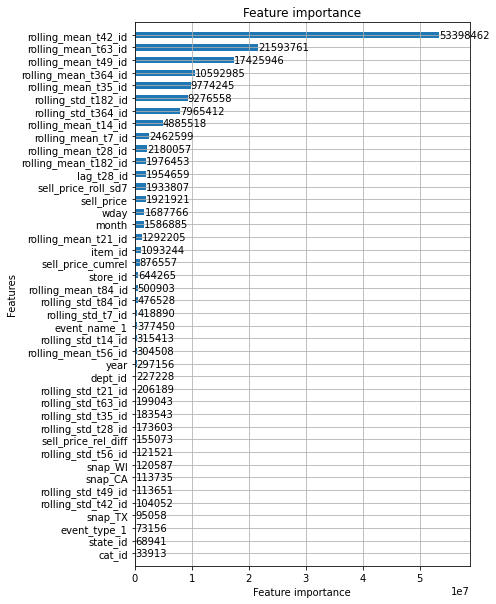

In [35]:
lgb.plot_importance(fit, importance_type="gain", precision=0, height=0.5, figsize=(6, 10));

In [36]:
# Validation & Visualization
'''

print('Saving model...')
# save model to file
fit.save_model('model.txt')

print('Loading model to predict...')
# load model to predict
fit = lgb.Booster(model_file='model.txt')


npz = np.load("./valid_data_label.npz")
valid_data = npz["data"]
#valid_data

valid_label = npz["label"]
#valid_label

pred = fit.predict(valid_data)

#plt.figure(14, 6)
plt.plot(range(28), valid_label[:28], color='blue')
plt.plot(range(28), pred[:28], color='red');
'''

'\n\nprint(\'Saving model...\')\n# save model to file\nfit.save_model(\'model.txt\')\n\nprint(\'Loading model to predict...\')\n# load model to predict\nfit = lgb.Booster(model_file=\'model.txt\')\n\n\nnpz = np.load("./valid_data_label.npz")\nvalid_data = npz["data"]\n#valid_data\n\nvalid_label = npz["label"]\n#valid_label\n\npred = fit.predict(valid_data)\n\n#plt.figure(14, 6)\nplt.plot(range(28), valid_label[:28], color=\'blue\')\nplt.plot(range(28), pred[:28], color=\'red\');\n'

In [37]:
pred = fit.predict(test[x])

# The dark magic -> credits: https://www.kaggle.com/kyakovlev/m5-dark-magic
pred_calibrated = pred / pred[test["id"].str.endswith("validation")].mean() * 1.447147

In [38]:
test["demand"] = pred_calibrated
#test["demand"] = pred
submission = test.pivot(index="id", columns="F", values="demand").reset_index()[sample_submission.columns]
submission.head()

F,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_evaluation,0.061447,0.056024,0.055453,0.056062,0.062975,0.090256,0.087766,0.061327,0.056024,...,0.041983,0.058817,0.057712,0.039488,0.035537,0.035361,0.035720,0.040176,0.058756,0.055131
1,FOODS_1_001_CA_1_validation,0.774729,0.735806,0.746152,0.703384,0.989748,1.039084,0.972588,0.923342,0.903044,...,0.988543,1.268164,1.125399,0.957094,0.935769,0.916974,0.866749,1.061474,1.251311,1.103016
2,FOODS_1_001_CA_2_evaluation,0.058104,0.053326,0.052899,0.053452,0.060059,0.085115,0.079490,0.058836,0.053326,...,0.069207,0.103948,0.099509,0.064151,0.057916,0.057692,0.058040,0.067126,0.103754,0.093290
3,FOODS_1_001_CA_2_validation,0.819393,0.795240,0.770128,0.768653,0.875705,0.946626,0.631071,0.791662,0.844203,...,0.969382,0.955087,1.582589,0.997250,1.035321,1.017689,1.157492,1.135288,1.317039,1.511498
4,FOODS_1_001_CA_3_evaluation,0.084936,0.077511,0.077974,0.078308,0.084288,0.113057,0.109218,0.085246,0.077511,...,0.056735,0.075324,0.071497,0.053840,0.048610,0.049142,0.049330,0.053455,0.075332,0.069358


In [39]:
submission.to_csv("submission.csv", index=False)

In [40]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "20200505(2)" # df[new_col_09] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*2).std()) added

In [41]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "20200505(3)" 
''' with base_features = ['lag_t7_', 'lag_t14_', 'lag_t21_', 'lag_t28_', 'lag_t63_', 'lag_t84_', 'lag_t182_', 
                          'rolling_mean_t7_', 'rolling_mean_t14_', 'rolling_mean_t21_', 'rolling_mean_t28_', 'rolling_mean_t63_', 'rolling_mean_t84_', 'rolling_mean_t182_',
                          'rolling_std_t7_', 'rolling_std_t14_', 'rolling_std_t21_', 'rolling_std_t28_', 'rolling_std_t63_', 'rolling_std_t84_', 'rolling_std_t182_']
'''

" with base_features = ['lag_t7_', 'lag_t14_', 'lag_t21_', 'lag_t28_', 'lag_t63_', 'lag_t84_', 'lag_t182_', \n                          'rolling_mean_t7_', 'rolling_mean_t14_', 'rolling_mean_t21_', 'rolling_mean_t28_', 'rolling_mean_t63_', 'rolling_mean_t84_', 'rolling_mean_t182_',\n                          'rolling_std_t7_', 'rolling_std_t14_', 'rolling_std_t21_', 'rolling_std_t28_', 'rolling_std_t63_', 'rolling_std_t84_', 'rolling_std_t182_']\n"

In [42]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "20200506(1) remove from lag7 from lag182 but lag28"  # 0.54475

In [43]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "20200506(2) increase num of leaves from 63 to 63*2" # 0.54823

In [44]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "20200506(3) reduce learning rate from 0.08 to 0.04 and increase num boost round from 2100 to 4200" # 0.54979

In [45]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "20200507(1) add std35, std42, std49 and std56" # 0.54771

In [46]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "20200507(2) add std364" # 0.55362

In [47]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "20200507(3) add mean364" # 0.56688

In [48]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "20200508(1) add mean35" # 0.56041

In [49]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "20200508(2) add mean42, mean49 and mean56" # 0.55153